# PCManifold class tutorial: Gaussian Process Regression

We approximate functions on the swissroll manifold through a Gaussian Process.
The functions will be maps from Diffusion Map coordinates back to the x,y,z coordinates.

In [1]:
# import all necessary packages
import numpy as np

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

%matplotlib inline

from sklearn.datasets import make_swiss_roll, make_s_curve
from sklearn.decomposition import PCA
import sklearn.manifold as manifold

import datafold.pcfold as pfold
import datafold.dynfold as dfold
from datafold.pcfold.kernels import RadialBasisKernel, OUKernel

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

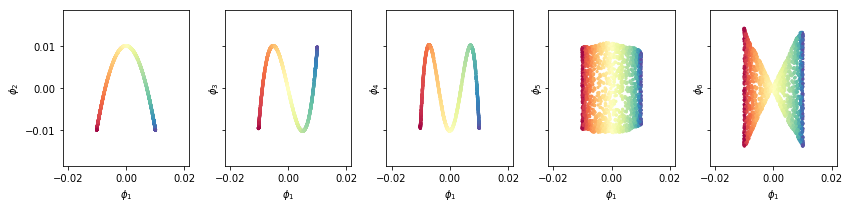

In [4]:
nr_samples = 20000
np.random.seed(5)

fig = plt.figure(figsize=(8, 8))

# generating the nonlinear dataset
nonlinear_data, color_nonlinear = make_s_curve(nr_samples, noise=0)  # using scikit learn package

plot_idx = np.random.permutation(nr_samples)[0:2000]

# Construct the PCManifold, estimate parameters, run diffusion maps (see dmaps tutorial)

pcm = pfold.PCManifold(nonlinear_data, dist_backend="scipy.kdtree")
pcm.optimize_parameters()

dmap = dfold.DiffusionMaps(epsilon=pcm.kernel.epsilon, cut_off=pcm.cut_off, n_eigenpairs=10)
dmap = dmap.fit(pcm)
evecs, evals = dmap.eigenvectors_, dmap.eigenvalues_

fig = plt.figure(figsize=(8, 8));

fig, ax = plt.subplots(1, 5, figsize=(12, 3), sharey=True);
for k in range(len(ax)):
    ax[k].scatter(evecs[plot_idx, 1], evecs[plot_idx, 2 + k], s=5, c=color_nonlinear[plot_idx],
                  cmap=plt.cm.Spectral);
    ax[k].set_xlabel(r"$\phi_1$");
    ax[k].set_ylabel(r"$\phi_%g$" % (k + 2));
fig.tight_layout()


In [ ]:
# construct a gaussian process on the dmap coordinates 1 and 5

subsample_indices = np.arange(evecs.shape[0])[0::2]
ev_indices = [1,5]
in_data = evecs[subsample_indices,:]
pcm_dmaps = pfold.PCManifold(in_data[:,ev_indices], dist_backend="scipy.kdtree")
pcm_dmaps.optimize_parameters(result_scaling=1)  # you can scale the optimization results a little to get a smoother gp result
#pcm_dmaps.cut_off = .005
print(pcm_dmaps.cut_off)
#pcm_dmaps.kernel = RadialBasisKernel(epsilon=.1)

# TODO this option is currently not supported by the distance
# pcm_dmaps.setup_metric('kmin',25)
gp = dfold.PCMGPRegression(pcm=pcm_dmaps)

solver_tolerance = 1e-2  # tolerance for the eigensolver of the GP. can be pretty large, >1e-4

# compute the GP parameters for the map back to the xyz coordinates
gp.regression(fx=nonlinear_data[subsample_indices,:], regression_scale=pcm_dmaps.kernel.epsilon,
              solver_tolerance=solver_tolerance);

In [ ]:
# now, evaluate the gp on new data
new_phis = evecs[:,ev_indices]
new_phis = new_phis[0:10000, :] * .95
new_phis += (np.random.rand(new_phis.shape[0], new_phis.shape[1]) - .5) / 80000

new_data = gp.evaluate(new_phis)

print(new_data.shape)

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.scatter(new_phis[:, 0], new_phis[:, 1], s=.1, c='k')
ax.scatter(evecs[plot_idx, 1], evecs[plot_idx, 5], s=1, c=color_nonlinear[plot_idx])
ax.set_title("original and new dmap points");

ax = fig.add_subplot(122, projection='3d')
ax.scatter(*new_data.T, s=1, c=color_nonlinear[0:new_data.shape[0]])
ax.view_init(10, 70)
ax.set_title("generated manifold");

# Gaussian Processes function sampling

We can sample random functions on arbitrary point clouds, with specific smoothness properties (e.g., $C^\infty$ or $W^{2,p}$).
The properties are set by choosing a kernel.

In [ ]:
# use a simple line as a point cloud
x = np.linspace(0, 1, 1000).reshape(-1, 1)

# different scales means functions with different Dirichlet energies (i.e. "more or less oscillatory")
scales = [0.01, 0.1, 1]
n_functions = 10

# choosing the gaussian kernel means all sampled functions are smooth, C^\infty
pcm = pfold.PCManifold(x, kernel=RadialBasisKernel(epsilon=1.0), dist_backend="brute")  # set it to a relatively large value for very smooth functions

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i in range(len(ax)):
    # this is to align with previous results that have another definition of the RBF kernel (differnt length scale)
    pcm.kernel.epsilon = 0.5 * scales[i]**2
    f_new = dfold.PCMGPRegression.sample(pcm, n_functions=n_functions)
    for k in range(f_new.shape[1]):
        ax[i].plot(x, f_new[:, k], lw=.5)
    ax[i].set_title("Kernel scale: %.2f" % (pcm.kernel.epsilon ))

# choosing the Ohrenstein-Uhlenbeck kernel means all sampled functions are no-where differentiable
pcm.kernel = OUKernel(epsilon=1)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i in range(len(ax)):
    pcm.kernel.epsilon = scales[i]
    f_new = dfold.PCMGPRegression.sample(pcm, n_functions=n_functions)
    for k in range(f_new.shape[1]):
        ax[i].plot(x, f_new[:, k], lw=.5)
    ax[i].set_title("Kernel scale: %.2f" % scales[i])